In this project, we are going to apply machine learning algorithms to predict the price of a house using 'AmesHousing.tsv'. In order to do so, we'll have to transform the data and apply various feature engineering techniques.

We will be focusing on the linear regression model, and use RMSE as the error metric. First let's explore the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

pd.set_option('display.max_columns', 500)
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')

In [2]:
print(data.shape)
print(len(str(data.shape))*'-')
print(data.dtypes.value_counts())
data.head()

(2930, 82)
----------
object     43
int64      28
float64    11
dtype: int64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Data Cleaning and Features Engineering

---

This dataset has a total of 82 columns and 2930 rows. Since we'll be using the linear regression model, we can only use numerical values in our model. One of the most important aspects of machine learning is knowing the features. Here are a couple things we can do to clean up the data:

+ The 'Order' and 'PID' columns are not useful for machine learning as they are simply identification numbers.  

+ It doesn't make much sense to use 'Year built' and 'Year Remod/Add' in our model. We should generate a new column to determine how old the house is since the last remodelling.  

+ We want to drop columns with too many missing values, let's start with 5% for now.  

+ We don't want to leak sales information to our model. Sales information will not be available to us when we actually use the model to estimate the price of a house.

In [3]:
#Create a new feature, 'years_to_sell'.
data['years_to_sell'] = data['Yr Sold'] - data['Year Remod/Add'] 
data = data[data['years_to_sell'] >= 0]

#Remove features that are not useful for machine learning.
data = data.drop(['Order', 'PID'], axis=1)

#Remove features that leak sales data.
data = data.drop(['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], axis=1)

#Drop columns with more than 5% missing values
is_null_counts = data.isnull().sum()
features_col = is_null_counts[is_null_counts < 2930*0.05].index


data = data[features_col]
data.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_to_sell
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,215000,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,105000,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,172000,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,244000,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,189900,12


Since we are dealing with a dataset with a large number a columns, it is a good idea to split the data up into two dataframes. We'll first work with the 'float' and 'int' columns. Then we'll set 'object' columns to a new dataframe. Once both dataframes contain only numerical values, we can combine them again and use the features for our linear regression model.

There are qutie a bit of NA values in the numerical columns, so we'll fill them up with the mode. Some of the columns are categorical, so it wouldn't make sense to use median or mean for this.

In [4]:
numerical_cols = data.dtypes[data.dtypes != 'object'].index
numerical_data = data[numerical_cols]

numerical_data = numerical_data.fillna(data.mode().iloc[0])
numerical_data.isnull().sum().sort_values(ascending = False)

years_to_sell      0
BsmtFin SF 2       0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 1       0
SalePrice          0
Mas Vnr Area       0
Year Remod/Add     0
Year Built         0
Overall Cond       0
Overall Qual       0
Lot Area           0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
MS SubClass        0
dtype: int64

Next, let's check the correlations of all the numerical columns with respect to 'SalePrice'

In [5]:
num_corr = numerical_data.corr()['SalePrice'].abs().sort_values(ascending = False)
num_corr

SalePrice          1.000000
Overall Qual       0.801206
Gr Liv Area        0.717596
Garage Cars        0.648361
Total Bsmt SF      0.644012
Garage Area        0.641425
1st Flr SF         0.635185
Year Built         0.558490
Full Bath          0.546118
years_to_sell      0.534985
Year Remod/Add     0.533007
Mas Vnr Area       0.506983
TotRms AbvGrd      0.498574
Fireplaces         0.474831
BsmtFin SF 1       0.439284
Wood Deck SF       0.328183
Open Porch SF      0.316262
Half Bath          0.284871
Bsmt Full Bath     0.276258
2nd Flr SF         0.269601
Lot Area           0.267520
Bsmt Unf SF        0.182751
Bedroom AbvGr      0.143916
Enclosed Porch     0.128685
Kitchen AbvGr      0.119760
Screen Porch       0.112280
Overall Cond       0.101540
MS SubClass        0.085128
Pool Area          0.068438
Low Qual Fin SF    0.037629
Bsmt Half Bath     0.035875
3Ssn Porch         0.032268
Misc Val           0.019273
BsmtFin SF 2       0.006127
Name: SalePrice, dtype: float64

We can drop values with less than 0.4 correlation for now. Later, we'll make this value an adjustable parameter in a function.

In [6]:
num_corr = num_corr[num_corr > 0.4]
high_corr_cols = num_corr.index

hi_corr_numerical_data = numerical_data[high_corr_cols]

For the 'object' or text columns, we'll drop any column with more than 1 missing value.

In [7]:
text_cols = data.dtypes[data.dtypes == 'object'].index
text_data = data[text_cols]

text_null_counts = text_data.isnull().sum()
text_not_null_cols = text_null_counts[text_null_counts < 1].index

text_data = text_data[text_not_null_cols]

From the documatation we want to convert any columns that are nominal into categories. 'MS subclass' is a numerical column but it should be categorical.

For the text columns, we'll take the list of nominal columns from the documentation and use a for loop to search for matches.

In [8]:
nominal_cols = ['MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style', 'Roof Mat1', 'Exterior 1st',  'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air'] 
nominal_num_col = ['MS SubClass']

In [9]:
#Finds nominal columns in text_data
nominal_text_col = []
for col in nominal_cols:
    if col in text_data.columns:
        nominal_text_col.append(col)
nominal_text_col

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

Simply use boolean filtering to keep the relevant columns in our text dataframe.

In [10]:
text_data = text_data[nominal_text_col]

In [11]:
for col in nominal_text_col:
    print(col)
    print(text_data[col].value_counts())
    print("-"*10)

MS Zoning
RL         2270
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: MS Zoning, dtype: int64
----------
Street
Pave    2915
Grvl      12
Name: Street, dtype: int64
----------
Land Contour
Lvl    2632
HLS     120
Bnk     115
Low      60
Name: Land Contour, dtype: int64
----------
Lot Config
Inside     2138
Corner      510
CulDSac     180
FR2          85
FR3          14
Name: Lot Config, dtype: int64
----------
Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    165
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64
----------
Condition 1
Norm      2520
Feedr      164
Artery   

Columns with too many categories can cause overfitting. We'll remove any columns with more than 10 categories. We'll write a function later to adjust this as a parameter in our feature selection.

In [12]:
nominal_text_col_unique = []
for col in nominal_text_col:
    if len(text_data[col].value_counts()) <= 10:
        nominal_text_col_unique.append(col)
               
text_data = text_data[nominal_text_col_unique]

Finally, we can use the pd.get_dummies function to create dummy columns for all the categorical columns. 

In [13]:
#Create dummy columns for nominal text columns, then create a dataframe.
for col in text_data.columns:
    text_data[col] = text_data[col].astype('category')   
categorical_text_data = pd.get_dummies(text_data)    
categorical_text_data.head()

,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_N,Central Air_Y
0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [14]:
#Create dummy columns for nominal numerical columns, then create a dataframe.
for col in numerical_data.columns:
    if col in nominal_num_col:
        numerical_data[col] = numerical_data[col].astype('category')  
              
categorical_numerical_data = pd.get_dummies(numerical_data.select_dtypes(include=['category'])) 

Using the pd.concat() function, we can combine the two categorical columns together.

In [15]:
categorical_data = pd.concat([categorical_text_data, categorical_numerical_data], axis=1)

We end up with one numerical dataframe, and one categorical dataframe. We can then combine them into one dataframe for machine learning.

In [16]:
hi_corr_numerical_data.head()

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Total Bsmt SF,Garage Area,1st Flr SF,Year Built,Full Bath,years_to_sell,Year Remod/Add,Mas Vnr Area,TotRms AbvGrd,Fireplaces,BsmtFin SF 1
0,215000,6,1656,2.0,1080.0,528.0,1656,1960,1,50,1960,112.0,7,2,639.0
1,105000,5,896,1.0,882.0,730.0,896,1961,1,49,1961,0.0,5,0,468.0
2,172000,6,1329,1.0,1329.0,312.0,1329,1958,1,52,1958,108.0,6,0,923.0
3,244000,7,2110,2.0,2110.0,522.0,2110,1968,2,42,1968,0.0,8,2,1065.0
4,189900,5,1629,2.0,928.0,482.0,928,1997,2,12,1998,0.0,6,1,791.0


In [17]:
categorical_data.head()

,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_N,Central Air_Y,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190
0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
final_data = pd.concat([hi_corr_numerical_data, categorical_data], axis=1)

### Creating Functions with Adjustable Parameters

---

When we did our data cleaning, we decided to remove columns that had more than 5% missing values. We can incorporate our this into a function as an adjustable parameter. In addition, this function will perform all the data cleaning operations I've explained above.

In [19]:
def transform_features(data, percent_missing=0.05):
    
    #Adding relevant features:
    data['years_since_remod'] = data['Year Built'] - data['Year Remod/Add']
    data['years_to_sell'] = data['Yr Sold'] - data['Year Built']
    data = data[data['years_since_remod'] >= 0]
    data = data[data['years_to_sell'] >= 0]
    
    #Remove columns not useful for machine learning
    data = data.drop(['Order', 'PID', 'Year Built', 'Year Remod/Add'], axis=1)
    
    #Remove columns that leaks sale data
    data = data.drop(['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], axis=1)
    
    #Drop columns with too many missing values defined by the function
    is_null_counts = data.isnull().sum()
    low_NaN_cols = is_null_counts[is_null_counts < len(data)*percent_missing].index
    
    transformed_data = data[low_NaN_cols]    
    return transformed_data

For the feature engineering and selection step, we chose columns that had more than 0.4 correlation with 'SalePrice' and removed any columns with more than 10 categories.

Once again, I've combined all the work we've done previously into a function with adjustable parameters.

In [20]:
def select_features(data, corr_threshold=0.4, unique_threshold=10):  
    
    #Fill missing numerical columns with the mode.
    numerical_cols = data.dtypes[data.dtypes != 'object'].index
    numerical_data = data[numerical_cols]

    numerical_data = numerical_data.fillna(data.mode().iloc[0])
    numerical_data.isnull().sum().sort_values(ascending = False)

    #Drop text columns with more than 1 missing value.
    text_cols = data.dtypes[data.dtypes == 'object'].index
    text_data = data[text_cols]

    text_null_counts = text_data.isnull().sum()
    text_not_null_cols = text_null_counts[text_null_counts < 1].index

    text_data = text_data[text_not_null_cols]

    num_corr = numerical_data.corr()['SalePrice'].abs().sort_values(ascending = False)

    num_corr = num_corr[num_corr > corr_threshold]
    high_corr_cols = num_corr.index

    #Apply the correlation threshold parameter
    hi_corr_numerical_data = numerical_data[high_corr_cols]
    

    #Nominal columns from the documentation
    nominal_cols = ['MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style', 'Roof Mat1', 'Exterior 1st',  'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air'] 
    nominal_num_col = ['MS SubClass']

    #Finds nominal columns in text_data
    nominal_text_col = []
    for col in nominal_cols:
        if col in text_data.columns:
            nominal_text_col.append(col)
    nominal_text_col

    text_data = text_data[nominal_text_col]

    nominal_text_col_unique = []
    for col in nominal_text_col:
        if len(text_data[col].value_counts()) <= unique_threshold:
            nominal_text_col_unique.append(col)
        
        
    text_data = text_data[nominal_text_col_unique]
    text_data.head()

    #Set all these columns to categorical
    for col in text_data.columns:
        text_data[col] = text_data[col].astype('category')   
    categorical_text_data = pd.get_dummies(text_data)    

    #Change any nominal numerical columns to categorical, then returns a dataframe
    for col in numerical_data.columns:
        if col in nominal_num_col:
            numerical_data[col] = numerical_data[col].astype('category')  
           
    
    categorical_numerical_data = pd.get_dummies(numerical_data.select_dtypes(include=['category'])) 
    final_data = pd.concat([hi_corr_numerical_data, categorical_text_data, categorical_numerical_data], axis=1)

    return final_data

### Applying Machine Learning

---

Now we are ready to apply machine learning, we'll use the linear regression model from scikit-learn. Linear regression should work well here since our target column 'SalePrice' is a continuous value. We'll evaluate this model with RMSE as an error metric.

In [21]:
def train_and_test(data):

    train = data[0:1460]
    test = data[1460:]
    features = data.columns.drop(['SalePrice'])
    
    #train
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    #predict
    
    predictions = lr.predict(test[features])
    rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
    return rmse

In [22]:
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')

transformed_data = transform_features(data, percent_missing=0.05)
final_data = select_features(transformed_data, 0.4, 10)
result = train_and_test(final_data)
result

28749.561761556044

We've selected the first 1460 rows as the training set, and the remaining data as the testing set. This is not really a good way to evaluate a model's performance because the error will change as soon as we shuffle the data. 

We can use KFold cross validation to split the data in K number of folds. Using the KFold function from scikit learn, we can get the indices for the testing and training sets.

In [29]:
from sklearn.model_selection import KFold

def train_and_test2(data, k=2):  
    rf = LinearRegression()
    if k == 0:
        train = data[0:1460]
        test = data[1460:]
        features = data.columns.drop(['SalePrice'])
    
        #train
        rf.fit(train[features], train['SalePrice'])
        
        #predict    
        predictions = rf.predict(test[features])
        rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
        return rmse
    
    elif k == 1:
        train = data[:1460]
        test = data[1460:]
        features = data.columns.drop(['SalePrice'])
        
        rf.fit(train[features], train["SalePrice"])
        predictions_one = rf.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        rf.fit(test[features], test["SalePrice"])
        predictions_two = rf.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        return np.mean([rmse_one, rmse_two])   
    
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state = 2)
        rmse_list = []
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            features = data.columns.drop(['SalePrice'])
    
            #train
            rf.fit(train[features], train['SalePrice'])
        
            #predict    
            predictions = rf.predict(test[features])
        
            rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
            rmse_list.append(rmse)
        return np.mean(rmse_list)

29830.6836474


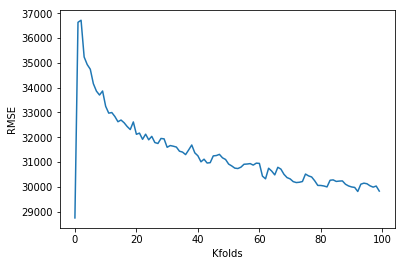

In [30]:
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')

transformed_data = transform_features(data, percent_missing=0.05)
final_data = select_features(transformed_data, 0.4, 10)

results = []
for i in range(100):
    result = train_and_test2(final_data, k=i)
    results.append(result)
    
x = [i for i in range(100)]
y = results 
plt.plot(x, y)
plt.xlabel('Kfolds')
plt.ylabel('RMSE')

print(results[99])

Our error is actually the lowest, when k = 0. This is acutally not very useful because it means the model is only useful for the indices we've picked out. Without validation there is no way to be sure that the model works well for any set of data.

This is when cross validation is useful for evaluating model performance. We can see the average RMSE goes down as we increase the number of folds. This makes sense as the RMSE shown on the graph above is an average of the cross validation tests. A larger K means we have less bias towards overestimating the model's true error. As a trade off, this requires a lot more computation time. 

---

#### Learning Summary

Concepts explored: pandas, data cleaning, features engineering, linear regression, hyperparameter tuning, RMSE, KFold validation

Functions and methods used: .dtypes, .value_counts(), .drop, .isnull(), sum(), .fillna(), .sort_values(), . corr(), .index, .append(), .get_dummies(), .astype(), predict(), .fit(), KFold(), mean_squared_error()


The files used for this project can be found in my [GitHub repository](https://github.com/sengkchu/Dataquest-Guided-Projects-Solutions/tree/master/Guided%20Project_%20Predicting%20House%20Sale%20Prices).